# Table of Contents:
* [0 -Importing Libraries](#0)
* [1 - Read in df](#1)
* [2 - SIR](#2)
* [3 - Descriptive Facts](#3)
* [4 - Prepare the dfset (change in turnout)](#4)
* [5 - Regressions](#5)

# 0) Imports <a class="anchor" id="0"></a>

In [36]:
import pandas as pd
import numpy as np
from numpy import nan
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import ast  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1) Read in df <a class="anchor" id="1"></a>

In [37]:
# Initialize an empty list to store the df
df = []

# Define keys based on the train_train_train_train_train_dfset format
keys = ['#*', '#@', '#t', '#c', '#index', '#%', '#!']

# Open the file and read the contents
with open('small.txt', 'r', encoding='ISO-8859-1') as file:
    current_paper = {}
    for line in file:
        line = line.strip()
        if line.startswith('#*'):
            # New paper starts; save the previous one if it exists
            if current_paper:
                df.append(current_paper)
                current_paper = {}
            current_paper['Title'] = line[2:].strip()
        elif line.startswith('#@'):
            current_paper['Authors'] = line[2:].strip()
        elif line.startswith('#t'):
            current_paper['Year'] = line[2:].strip()
        elif line.startswith('#c'):
            current_paper['Venue'] = line[2:].strip()
        elif line.startswith('#index'):
            current_paper['Index ID'] = line[6:].strip()
        elif line.startswith('#%'):
            if 'References' not in current_paper:
                current_paper['References'] = []
            current_paper['References'].append(line[2:].strip())
        elif line.startswith('#!'):
            current_paper['Abstract'] = line[2:].strip()
        elif line.isdigit() and current_paper:  # Handle end of current paper
            df.append(current_paper)
            current_paper = {}
    # Add the last paper
    if current_paper:
        df.append(current_paper)

# Convert list of dicts to dfFrame
df = pd.DataFrame(df)

# Replacing missing keys with None which becomes NaN in dfFrame
for key in ['Title', 'Authors', 'Year', 'Venue', 'Index ID', 'References', 'Abstract']:
    if key not in df.columns:
        df[key] = None

In [38]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Index ID'] = pd.to_numeric(df['Index ID'], errors='coerce')
# Apply the function to the dfFrame column
df['References'] = df['References'].apply(
    lambda x: [int(i) for i in x] if isinstance(x, list) else x
)

Last Cited Year (for SIR)

In [39]:
# Creating a dictionary from the dfFrame assuming 'Index ID' and 'Year' are columns in your dfFrame
year_dict = df.set_index('Index ID')['Year'].to_dict()

def get_last_cited_year(ref_ids):
    if not isinstance(ref_ids, list):
        return np.nan
    # Filter and collect years where reference IDs exist in year_dict
    years = [year_dict.get(int(ref_id)) for ref_id in ref_ids if int(ref_id) in year_dict]
    return max(years) if years else np.nan

# Apply the function to the 'References' column to compute the 'Last Cited Year'
df['Last Cited Year'] = df['References'].apply(get_last_cited_year)
df["Venue"] = df["Venue"].astype(str)
df['Venue'] = df['Venue'].replace('', np.nan)
df["References Count"] = df["References"].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [40]:
# Calculate total authors
df['Authors'] = df['Authors'].fillna('')  # Fill empty strings where there are no authors
unique_authors = set()
df['Authors'].apply(lambda x: unique_authors.update(x.split(',')) if x else None)
total_authors = len(unique_authors) - 1 if '' in unique_authors else len(unique_authors)

# Fill missing Venue values with "Unknown"
df['Venue'] = df['Venue'].fillna("Unknown")

# Determine CITING based on whether References is populated
df['Citing'] = df['References'].notna()

# Determine ARCHIVED status based on Last Cited Year
latest_year = df['Year'].max()  # Get the latest year in the dfset
df['Archived'] = df.apply(lambda x: x['Last Cited Year'] < (latest_year - 5) if pd.notna(x['Last Cited Year']) else False, axis=1)

# Simulating UNLINKED papers, assume a 5% error rate for now
df['Unlinked'] = df['Citing'] & (np.random.rand(len(df)) < 0.05)

In [41]:
# Define the high-impact venues
high_impact_venues = [
    "Nature", 
    "Science", 
    "Advances in Neural Information Processing Systems 5", 
    "[NIPS Conference]"
]

# Function to check if the venue is high-impact
def is_high_impact(venue):
    if any(high in venue for high in high_impact_venues):
        return True
    if "International Conference on Machine Learning" in venue:
        return True
    return False

# Classify papers based on the defined criteria
df['CITING'] = df['References'].notna()
df['ARCHIVED'] = (df['Last Cited Year'] < (df['Year'].max() - 5)) & df['Last Cited Year'].notna()
df['EXPOSED'] = df['Venue'].apply(is_high_impact)
df['UNLINKED'] = df['Unlinked']  # This is already a boolean flag in the dfset
df["PENDING"] = False
# PENDING (P) category cannot be directly modeled from the df as it pertains to future papers


# 2) PACEU model <a class="anchor" id="2"></a>

In [42]:
# Reset index
df = df.sample(frac=1).reset_index(drop=True)

In [43]:
# Time-based split
train_df = df[df['Year'] <= 2005]
validation_df = df[(df['Year'] > 2005) & (df['Year'] <= 2007)]
test_df = df[df['Year'] > 2007]

## 2.1) Define intial conditions

In [44]:
# initial_year = 2000
# end_year = 2010
# time_points = end_year - initial_year + 1

In [45]:
def citation_model(y, t, lambda_, beta, gamma):
    P, E, C, A = y
    dP_dt = -lambda_ * P
    dE_dt = lambda_ * P - beta * E
    dC_dt = beta * E - gamma * C
    dA_dt = gamma * C
    return [dP_dt, dE_dt, dC_dt, dA_dt]

In [50]:
def calculate_parameters(train_df):
    lambda_vals, beta_vals, gamma_vals = [], [], []
    for year in range(int(train_df['Year'].min()), int(train_df['Year'].max())):
        exposed_previous_year = train_df[train_df['Year'] == year - 1]['EXPOSED'].sum()
        citing_previous_year = train_df[train_df['Year'] == year - 1]['CITING'].sum()

        new_exposed = train_df[train_df['Year'] == year]['EXPOSED'].sum() - exposed_previous_year
        new_citing = train_df[train_df['Year'] == year]['CITING'].sum() - citing_previous_year
        new_archived = train_df[train_df['Year'] == year]['ARCHIVED'].sum() - train_df[train_df['Year'] == year - 1]['ARCHIVED'].sum()

        total_papers = train_df[train_df['Year'] == year - 1].shape[0]

        lambda_vals.append(new_exposed / total_papers if total_papers > 0 else 0)
        beta_vals.append(new_citing / exposed_previous_year if exposed_previous_year > 0 else 0)
        gamma_vals.append(new_archived / citing_previous_year if citing_previous_year > 0 else 0)

    lambda_ = sum(lambda_vals) / len(lambda_vals)
    beta = sum(beta_vals) / len(beta_vals)
    gamma = sum(gamma_vals) / len(gamma_vals)

    return lambda_, beta, gamma

lambda_, beta, gamma = calculate_parameters(train_df)
params = (lambda_, beta, gamma)
print(f"Estimated \nlambda: {lambda_}, \nbeta: {beta}, \ngamma: {gamma}")

Estimated lambda: -9.078856886198546e-06, 
beta: 0.08331275655168219, 
gamma: 0.006316715182535637


In [47]:
# Param stablization


## 2.2) 

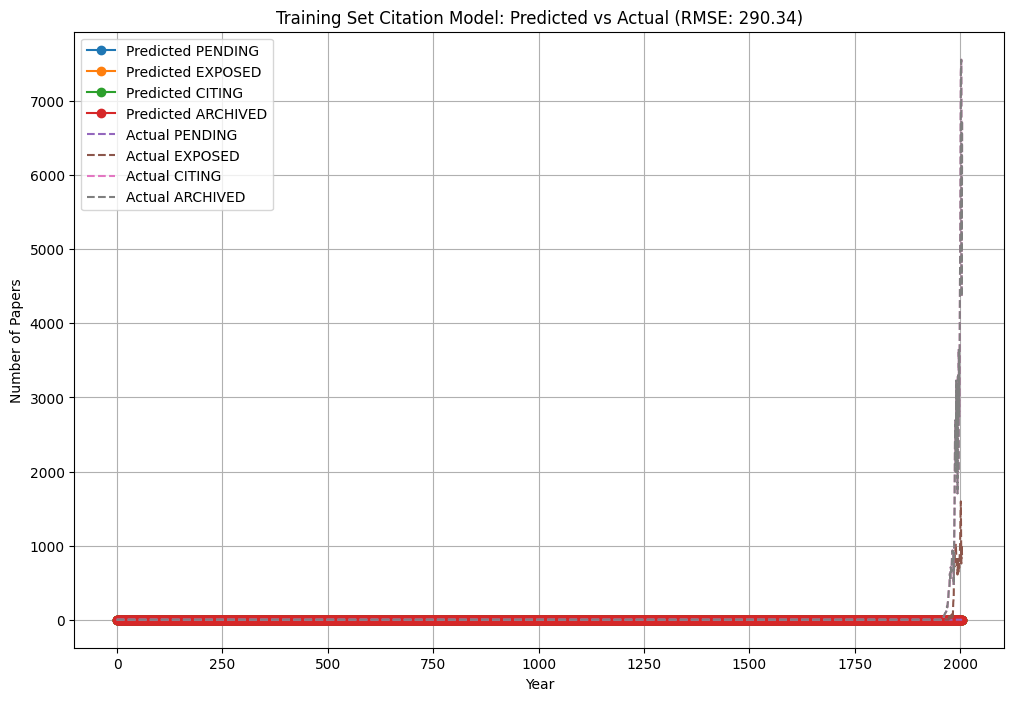

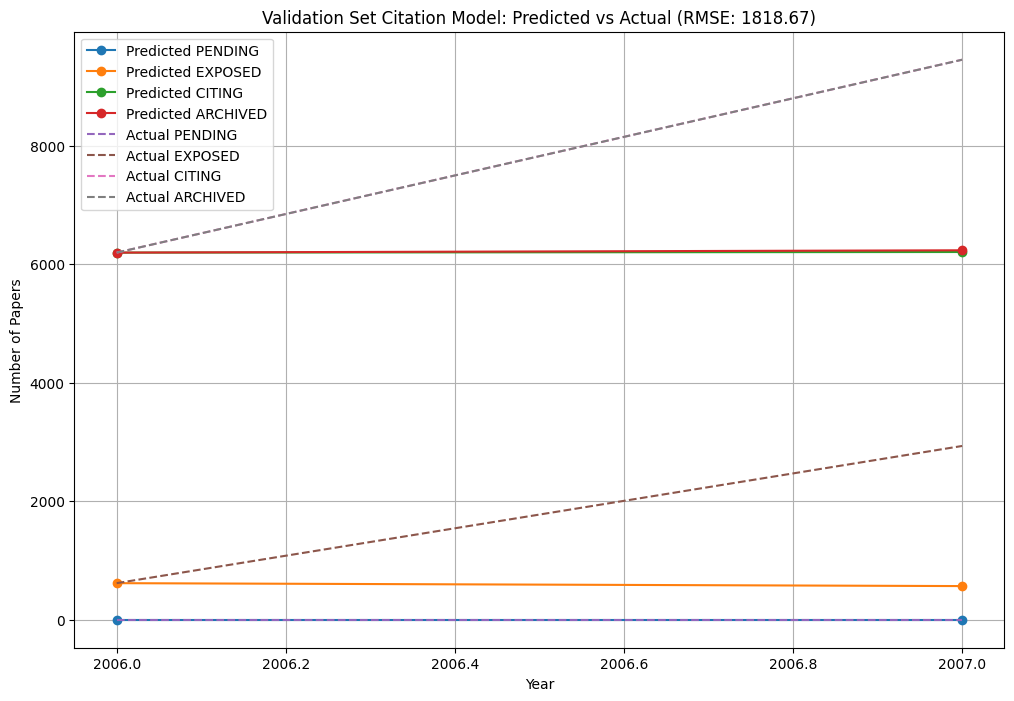

In [49]:
def run_simulation_and_plot(df, years, params, title):
    lambda_, beta, gamma = params
    P0 = df[df['Year'] == min(years)]['PENDING'].sum()
    E0 = df[df['Year'] == min(years)]['EXPOSED'].sum()
    C0 = df[df['Year'] == min(years)]['CITING'].sum()
    A0 = df[df['Year'] == min(years)]['ARCHIVED'].sum()
    y0 = [P0, E0, C0, A0]

    time_points = np.linspace(min(years), max(years), num=len(years))

    results = odeint(citation_model, y0, time_points, args=params)
    actual_data = [[df[df['Year'] == year]['PENDING'].sum(),
                    df[df['Year'] == year]['EXPOSED'].sum(),
                    df[df['Year'] == year]['CITING'].sum(),
                    df[df['Year'] == year]['ARCHIVED'].sum()] for year in years]

    rmse = np.sqrt(mean_squared_error(np.array(actual_data), results))
    plt.figure(figsize=(12, 8))
    plt.plot(time_points, results, marker='o')
    plt.plot(time_points, np.array(actual_data), linestyle='--')
    plt.title(f'{title}: Predicted vs Actual (RMSE: {rmse:.2f})')
    plt.xlabel('Year')
    plt.ylabel('Number of Papers')
    plt.legend(['Predicted PENDING', 'Predicted EXPOSED', 'Predicted CITING', 'Predicted ARCHIVED', 
                'Actual PENDING', 'Actual EXPOSED', 'Actual CITING', 'Actual ARCHIVED'], loc='upper left')
    plt.grid(True)
    plt.show()

    return rmse

# Running simulation on training set
training_years = list(range(int(train_df['Year'].min()), int(train_df['Year'].max()) + 1))
train_rmse = run_simulation_and_plot(train_df, training_years, params, 'Training Set Citation Model')

# Running simulation on validation set
validation_years = list(range(int(validation_df['Year'].min()), int(validation_df['Year'].max()) + 1))
validation_rmse = run_simulation_and_plot(validation_df, validation_years, params, 'Validation Set Citation Model')